In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import json
import wandb
import torch.nn as nn
from torch.utils.data import DataLoader

notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
print(sys.path)

from utils.base_utils import to_01, to_0c

from a_datasets.custom_dataset_classes import DiskDataset
from a_datasets.hdisks3 import random_two_disk_dataset
from utils.wandb_utils import load_from_wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

['/mnt/ceph/users/blyo1/projects', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python310.zip', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/lib-dynload', '', '/mnt/home/blyo1/venvs/py310/lib/python3.10/site-packages']


/mnt/home/blyo1/venvs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [4]:
# hierarchical dataset 3
data = random_two_disk_dataset(
    img_size=32,
    outer_radius=4,
    transition_width=2,
    d=10,
    num_imgs=5e4
)[0]

dataset = DiskDataset(data)
dataloader = DataLoader(dataset, batch_size=512, num_workers=4, shuffle=False)

# Load model

In [20]:
lvae = load_from_wandb('lvae', 78).to(device)
# vae = load_from_wandb('vae', 5).to(device)

CommError: artifact 'model-sccci1ha:latest' not found in 'blyo/lvae'

# Test models

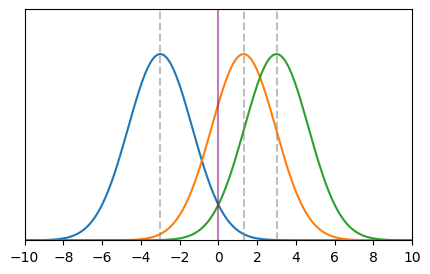

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# draw several gaussians
x = np.linspace(-16, 16, 200)
mus = [-3, 1.3, 3]
logvars = [1, 1, 1]
for mu, logvar in zip(mus, logvars):
    y = np.exp(-0.5 * (x - mu)**2 / np.exp(logvar)) / (np.sqrt(2 * np.pi * np.exp(logvar)))
    ax.plot(x, y)

# hide the y axis
ax.get_yaxis().set_visible(False)
ax.set_xlim(-10, 10)
ax.set_xticks(np.arange(-10, 11, 2));
ax.set_ylim(0, .3)

# draw vertical lines at the means
for mu in mus:
    ax.axvline(mu, color='gray', linestyle='--', alpha=0.5)

ax.axvline(0, color='purple', linestyle='-', alpha=0.5)

# save figure
fig.savefig('d_analysis/figures/lh_decoder.png', bbox_inches='tight', dpi=300)

In [15]:
img_idx = 11
test_img = to_0c(data[img_idx]).unsqueeze(1).to(device)

In [16]:
def test_on_one_img(model, test_img, criterion = nn.MSELoss()):
    model.eval()
    xout = model(test_img)[0]
    xout = xout.detach().cpu()
    xin = test_img.cpu()

    plot_test_one_img(xin, xout)

    # print(xin.min(), xout.min(), xin.max(), xout.max())
    test_loss = criterion(xin, xout).item()
    print(f"Test Loss: {test_loss:.4f}")
    return test_loss

def plot_test_one_img(xin, xout):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(to_01(xin).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
    ax[0].set_title("Input Image")
    ax[0].axis("off")
    ax[1].imshow(to_01(xout).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
    ax[1].set_title("Reconstructed Image")
    ax[1].axis("off")
    plt.show()

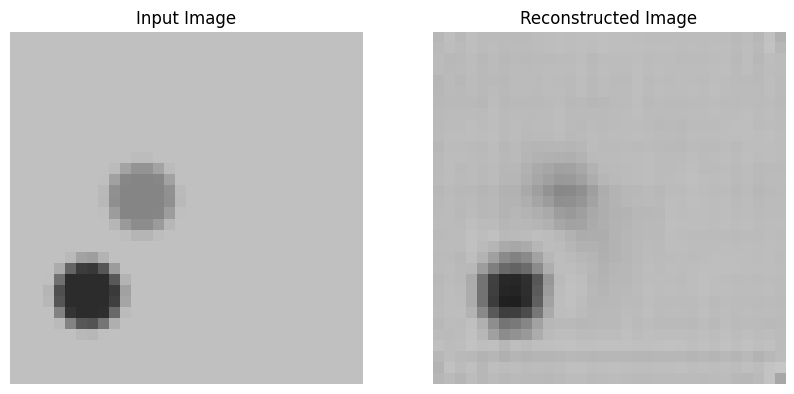

Test Loss: 0.0048


/mnt/home/blyo1/venvs/py310/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 32, 32])) that is different to the input size (torch.Size([1, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [17]:
test_on_one_img(vae, test_img);

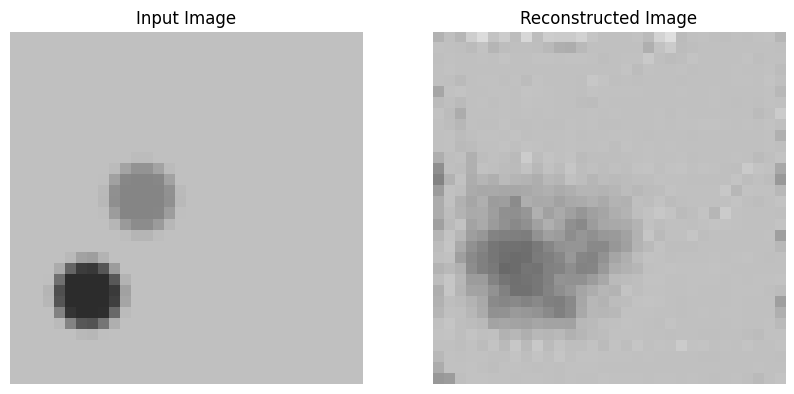

Test Loss: 0.0287


In [18]:
test_on_one_img(lvae, test_img);

In [11]:
test_imgs = to_0c(data[11:16]).to(device)

def test_on_multiple_imgs(model, test_imgs, criterion = nn.MSELoss()):
    model.eval()
    out = model(test_imgs)[0]
    xout = out.detach().cpu()
    xin = test_imgs.cpu()

    # print(xin.min(), xout.min(), xin.max(), xout.max())
    test_loss = criterion(xin, xout).item()
    print(f"Test Loss: {test_loss:.4f}")
    plot_test_multiple_imgs(xin, xout)
    return test_loss

def plot_test_multiple_imgs(xin, xout):
    fig, ax = plt.subplots(2, len(xin), figsize=(13, 5))
    for i in range(len(xin)):
        ax[0, i].imshow(to_01(xin[i]).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
        ax[0, i].axis("off");

        ax[1, i].imshow(to_01(xout[i]).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
        ax[1, i].axis("off");
    plt.show()

Test Loss: 0.5651


/mnt/home/blyo1/venvs/py310/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 32, 32])) that is different to the input size (torch.Size([5, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


IndexError: index 1 is out of bounds for dimension 0 with size 1

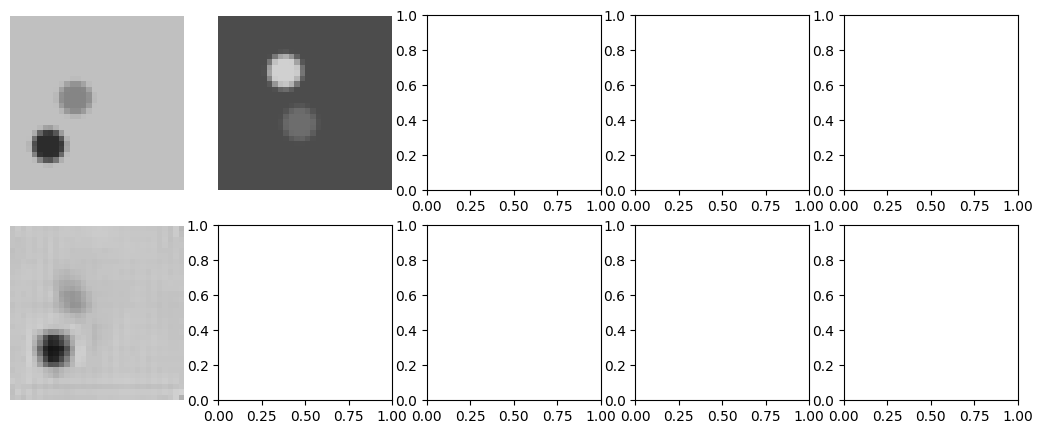

In [12]:
test_on_multiple_imgs(vae, test_imgs);

Test Loss: 0.0281


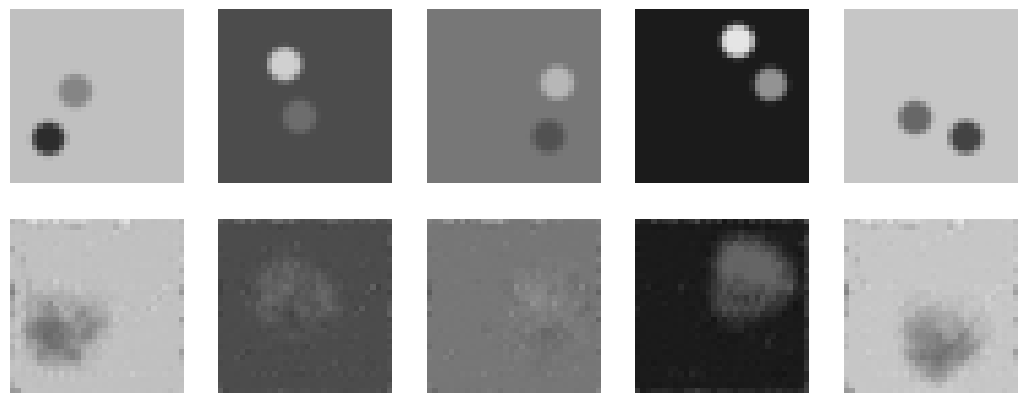

In [19]:
test_on_multiple_imgs(lvae, test_imgs);

# receptive field sizes

We're going to calculate the receptive field sizes for each of these models

In [ ]:
def calculate_rf(model):
    encoder = model.encoder
    modules = []
    for bu_block in encoder:
        conv_block = bu_block.conv_block
        # print(conv_block)
        pre_conv = conv_block.pre_conv
        modules.append(pre_conv)
        block = conv_block.block
        for layer in block:
            if isinstance(layer, nn.Conv2d):
                modules.append(layer)
    print('total number of modules that affect rf:', len(modules))

    # now calculate rf
    rf = 1
    j = 1
    for layer in modules:
        k, s, d = layer.kernel_size[0], layer.stride[0], layer.dilation[0]
        rf = rf + (k - 1) * j * d
        j = j * s
        print(rf)

print(calculate_rf(vae));